## Generate validation sims for Hydra
_Phil Bull, 2022-10-21_

This notebook uses hera_sim to generate validation simulations for Hydra.

In [1]:
import numpy as np
import pylab as plt

import pyuvdata
from pyuvdata import UVData, UVCal
import hera_sim, vis_cpu, pyuvsim

import astropy
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy.time import Time

import time, json

import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (10, 5)

np.random.seed(4)

### Basic simulation parameters

In [2]:
# Frequencies and times
Nfreqs = 20
Ntimes = 24
dt = 2.*60 # sec (2 mins)
jd = 2459873.83333 # 2022-10-21, 8pm UTC

# Frequency array
freqs = np.linspace(100., 120., Nfreqs) # MHz

# Array spec
hex_spec = (4,6) # (4,6)=24 ants, (4,7)=37 ants, (4,8)=52 ants

# Gain polynomial order and rms
gain_poly_order = 3
gain_poly_rms = 0.01

# Point source properties
Nptsrc = 100
Smin, Smax = 1e-1, 1e2 # Jy

# Output prefix
prefix = "sim_airy_100srcX"

In [3]:
# HERA location
location = EarthLocation.from_geodetic(lat=-30.7215,
                                       lon=21.4283,
                                       height=1073.)

# Observation time
obstime = Time(jd, format='jd')
print(obstime.iso)

# Time offsets from 'obstime'
times = np.linspace(0., Ntimes*dt, Ntimes) * u.second

2022-10-21 07:59:59.712


### Construct array layout

In [4]:
def build_hex_array(hex_spec=(3,4), ants_per_row=None, d=14.6):
    """
    Build an antenna position dict for a hexagonally close-packed array.
    
    Parameters
    ----------
    hex_spec : tuple, optional
        If `ants_per_row = None`, this is used to specify a hex array as 
        `hex_spec = (nmin, nmax)`, where `nmin` is the number of antennas in 
        the bottom and top rows, and `nmax` is the number in the middle row. 
        The number per row increases by 1 until the middle row is reached.
        
        Default: (3,4) [a hex with 3,4,3 antennas in each row]
    
    ants_per_row : array_like, optional
        Number of antennas per row. Default: None.
    
    d : float, optional
        Minimum baseline length between antennas in the hex array, in meters. 
        Default: 14.6.
    
    Returns
    -------
    ants : dict
        Dictionary with antenna IDs as the keys, and tuples with antenna 
        (x, y, z) position values (with respect to the array center) as the 
        values. Units: meters.
    """
    ants = {}
    
    # If ants_per_row isn't given, build it from hex_spec
    if ants_per_row is None:
        r = np.arange(hex_spec[0], hex_spec[1]+1).tolist()
        ants_per_row = r[:-1] + r[::-1]
    
    # Assign antennas
    k = -1
    y = 0.
    dy = d * np.sqrt(3) / 2. # delta y = d sin(60 deg)
    for j, r in enumerate(ants_per_row):
        
        # Calculate y coord and x offset
        y = -0.5 * dy * (len(ants_per_row)-1) + dy * j
        x = np.linspace(-d*(r-1)/2., d*(r-1)/2., r)
        for i in range(r):
            k += 1
            ants[k] = (x[i], y, 0.)
            
    return ants

In [5]:
# Construct array
ants = build_hex_array(hex_spec=hex_spec, ants_per_row=None, d=14.6)

(-50.0, 50.0)

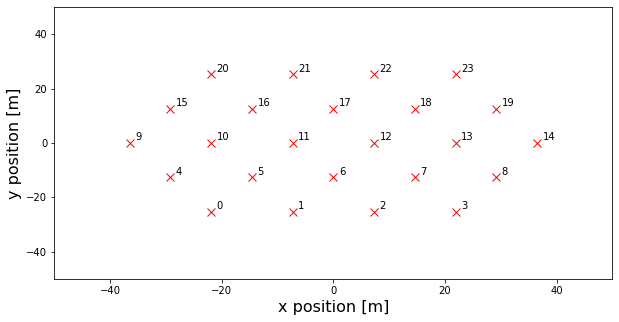

In [6]:
# Plot array layout
plt.subplot(111)
for i in ants:
    plt.plot(ants[i][0], ants[i][1], 'rx', ms=8)
    plt.text(ants[i][0]+1., ants[i][1]+1., "%d" % i)

plt.xlabel("x position [m]", fontsize=16)
plt.ylabel("y position [m]", fontsize=16)
plt.ylim((-50., 50.))
plt.xlim((-50., 50.))

In [7]:
len(ants)

24

### Power-law distribution of source fluxes

Text(0.5, 0, '$\\log_{10} S$ [Jy]')

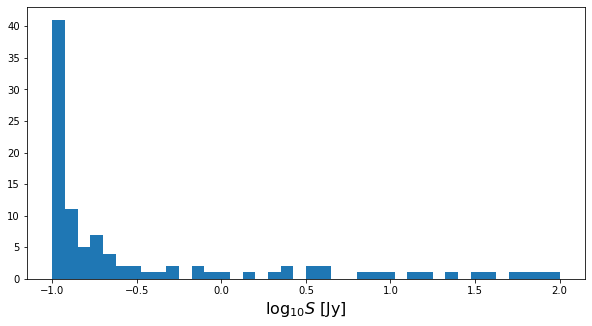

In [8]:
# Generate distribution of fluxes (using power law distribution here)
#logS = np.random.uniform(low=np.log10(Smin), high=np.log10(Smax), size=Nptsrc)
logS = np.random.power(0.2, size=Nptsrc)
logS = (logS - logS.min()) / (logS.max() - logS.min()) \
     * (np.log10(Smax) - np.log10(Smin)) + np.log10(Smin)
ptsrc_flux = 10.**(logS)

# Plot histogram
plt.subplot(111)
plt.hist(np.log10(ptsrc_flux), bins=40)
#plt.yscale('log')
plt.xlabel("$\log_{10} S$ [Jy]", fontsize=16)

Text(0.5, 0, 'Point source spectral index')

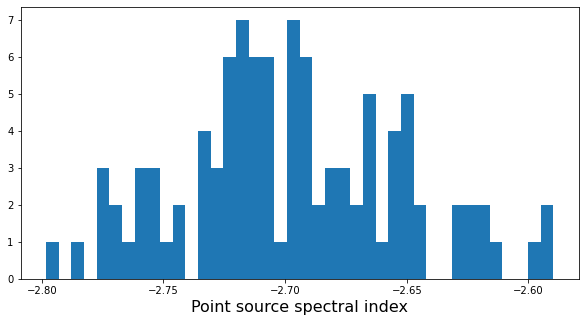

In [9]:
# Generate power-law spectral indices
ptsrc_beta = -2.7 + 0.05 * np.random.randn(Nptsrc)

# Plot histogram
plt.subplot(111)
plt.hist(ptsrc_beta, bins=40)
plt.xlabel("Point source spectral index", fontsize=16.)

In [10]:
# Location on sky (close to HERA zenith pointing)
ra = np.random.uniform(low=160., high=200., size=Nptsrc) # degrees
dec = -30.7 + 15. * np.random.randn(Nptsrc) # degrees

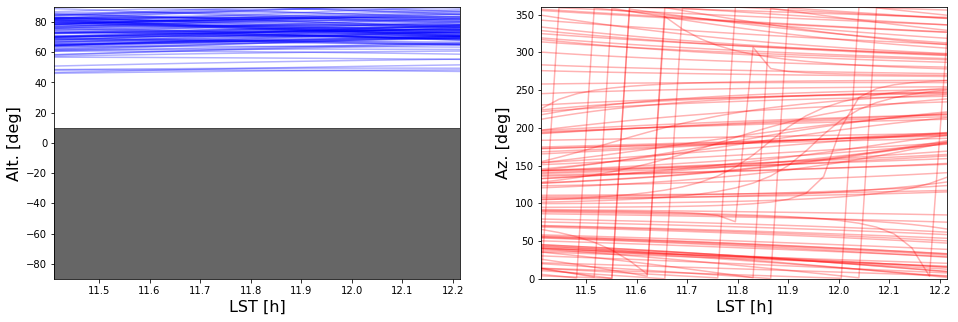

In [11]:
# Get altitude and azimuth vs LST
coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

# Loop over times
alt, az = [], []
lsts = []
for tt in times:
    frame = AltAz(obstime=obstime + tt, location=location)
    _c = coords.transform_to(frame)
    
    lsts.append((obstime + tt).sidereal_time('apparent', longitude=location.lon).rad)
    alt.append(_c.alt.deg)
    az.append(_c.az.deg)
    
alt = np.array(alt)
az = np.array(az)
lsts = np.array(lsts)

# Plot altitude and azimuth vs LST
plt.subplot(121)
plt.plot(lsts*24./(2.*np.pi), alt, color='b', alpha=0.3)
plt.axhspan(xmin=0., xmax=1., ymin=-90., ymax=10., color='k', alpha=0.6)
plt.xlabel("LST [h]", fontsize=16)
plt.ylabel("Alt. [deg]", fontsize=16)
plt.xlim((lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi)))
plt.ylim((-90., 90.))

plt.subplot(122)
plt.plot(lsts*24./(2.*np.pi), az, color='r', alpha=0.3)
plt.xlabel("LST [h]", fontsize=16)
plt.ylabel("Az. [deg]", fontsize=16)
plt.xlim((lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi)))
plt.ylim((0., 360.))

plt.gcf().set_size_inches((16., 5.))

Beam FWHM:  11.8 deg


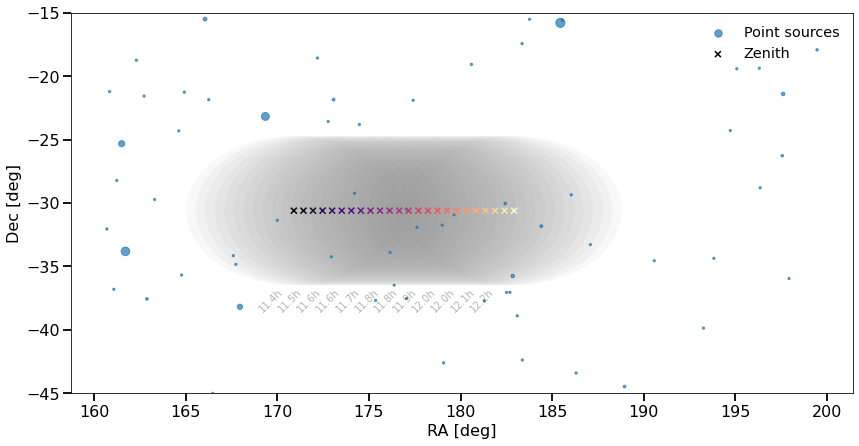

In [12]:
# Get RA/Dec track of zenith
zen_ra = []
zen_dec = []
for tt in times:
    zen = SkyCoord(alt=90.*u.deg, az=0.*u.deg, obstime=obstime + tt, location=location, frame='altaz')
    zen_ra.append(zen.icrs.ra.deg)
    zen_dec.append(zen.icrs.dec.deg)
zen_ra = np.array(zen_ra)
zen_dec = np.array(zen_dec)

# Plot locations of sources and zenith in equatorial coords
plt.subplot(111)
plt.scatter(ra, dec, s=5.+(ptsrc_flux), label="Point sources", alpha=0.7)
plt.scatter(zen_ra, zen_dec, c=lsts, marker='x', label="Zenith", cmap='magma')

# Plot approx. beam FWHM
beam_fwhm = (astropy.constants.c.value/(freqs[0]*1e6) / 14.6) * 180./np.pi
print("Beam FWHM: %5.1f deg" % beam_fwhm)
for i in range(zen_ra.size):
    circ = patches.Circle((zen_ra[i], zen_dec[i]), beam_fwhm/2., alpha=0.05, fc='gray', zorder=-100)
    plt.gca().add_patch(circ)
    if i % 2 == 0:
        plt.text(zen_ra[i] - 2., zen_dec[i] - 8., "%3.1fh" % (lsts[i]*24./(2.*np.pi)), rotation=45., alpha=0.3)

plt.legend(loc='upper right', frameon=False, prop={'size':'x-large'})
plt.xlabel("RA [deg]", fontsize=16)
plt.ylabel("Dec [deg]", fontsize=16)

plt.ylim((-45., -15.))
plt.gca().tick_params(which='both', labelsize=16, size=8., width=1.8)

plt.gcf().set_size_inches((14., 7.))

### Simple per-antenna gain model
The gains should be smooth. They will be modelled using a 2D Fourier series, but we will simulate them using smooth, aperiodic functions (just polynomials).

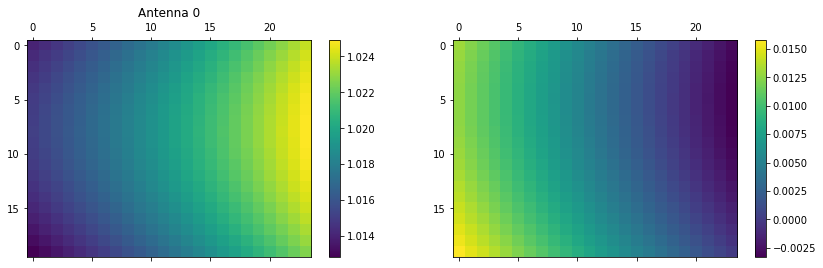

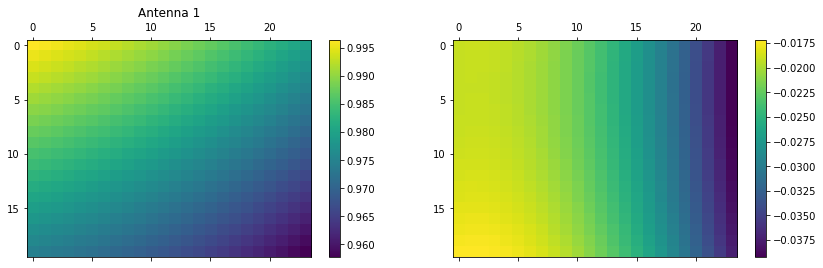

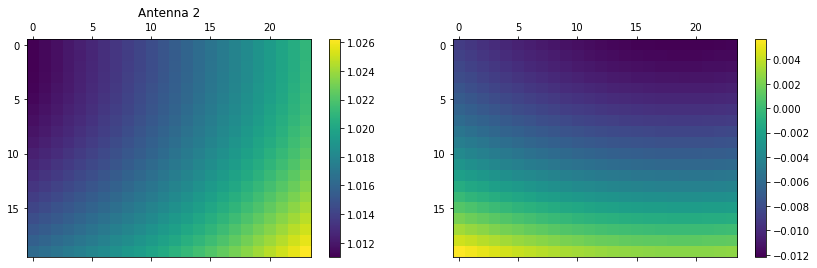

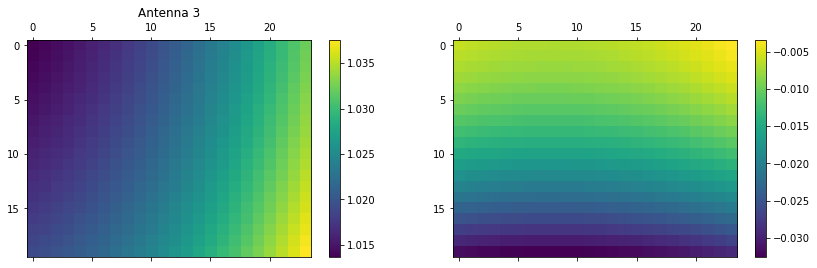

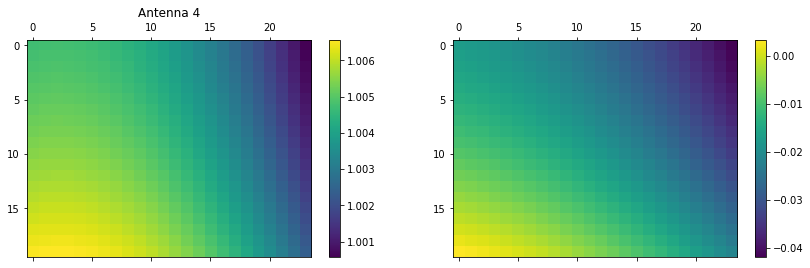

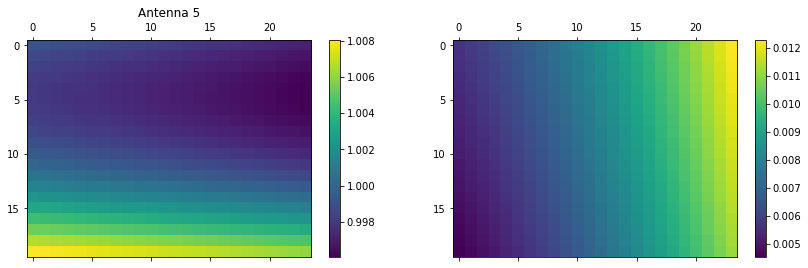

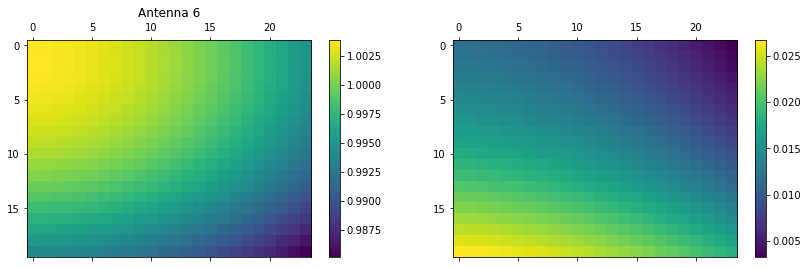

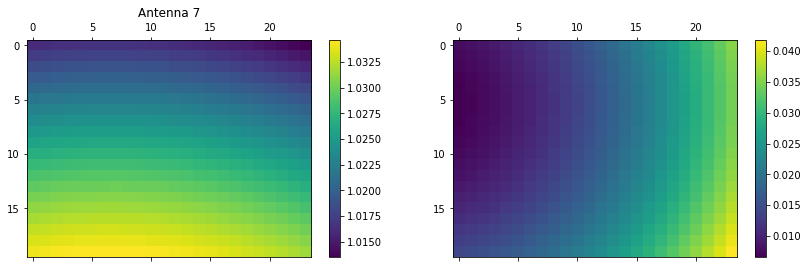

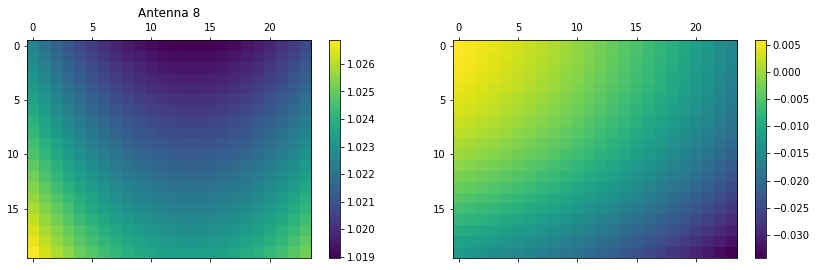

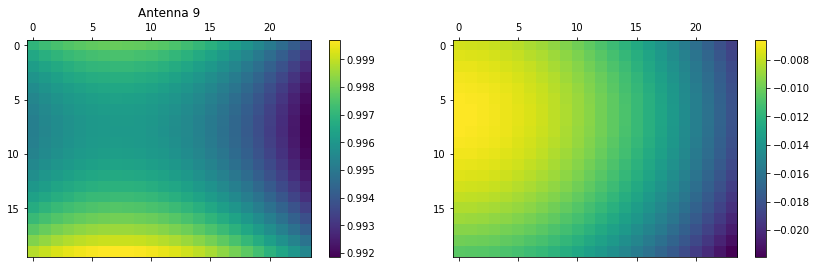

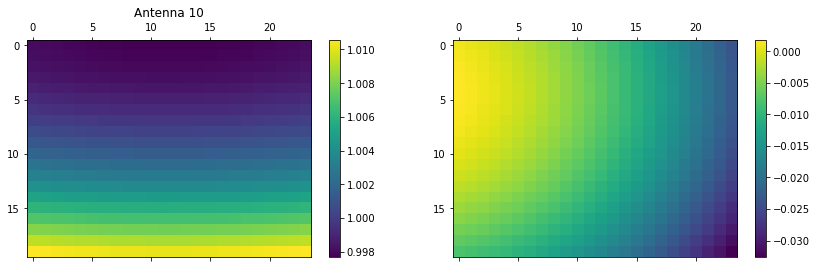

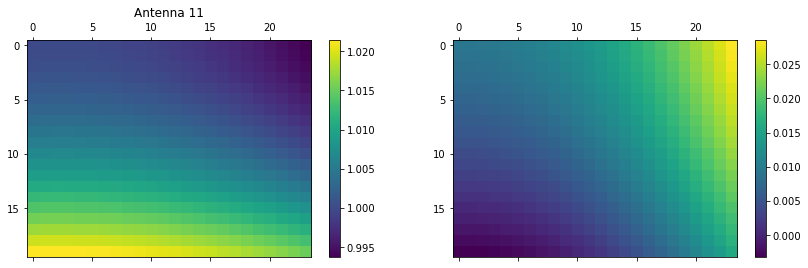

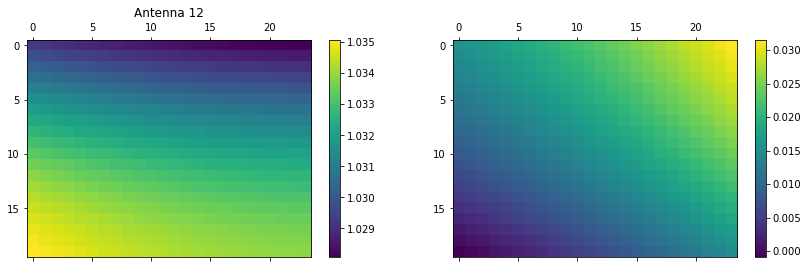

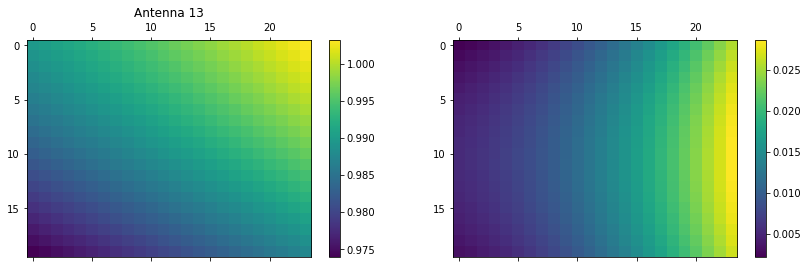

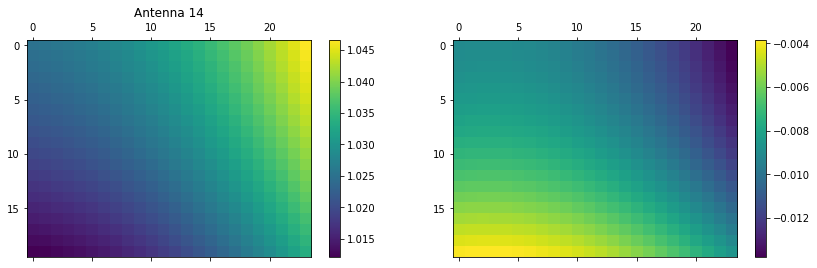

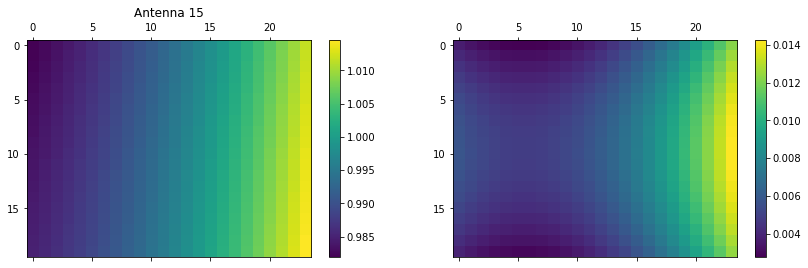

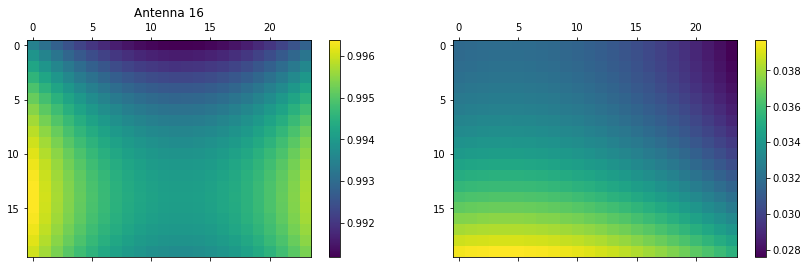

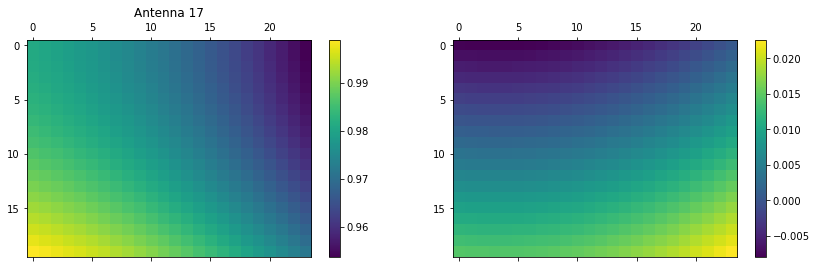

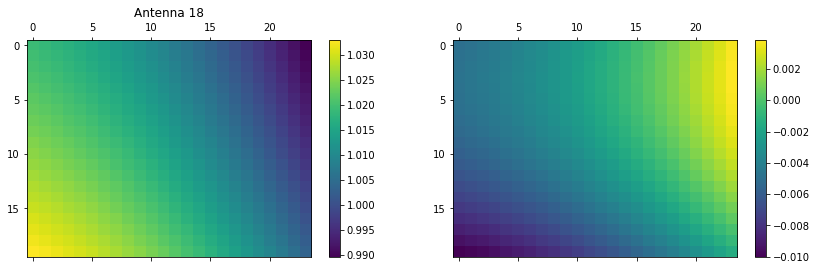

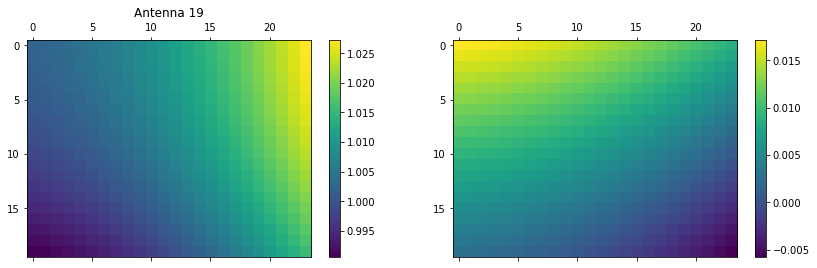

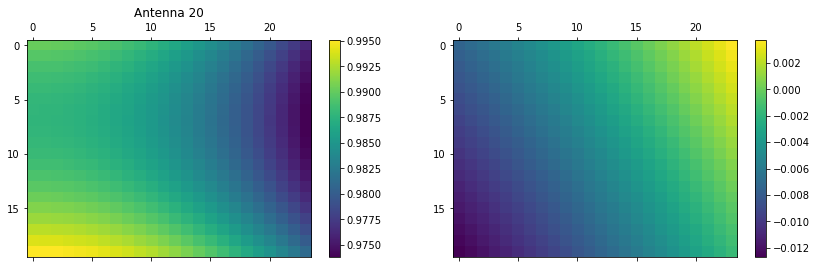

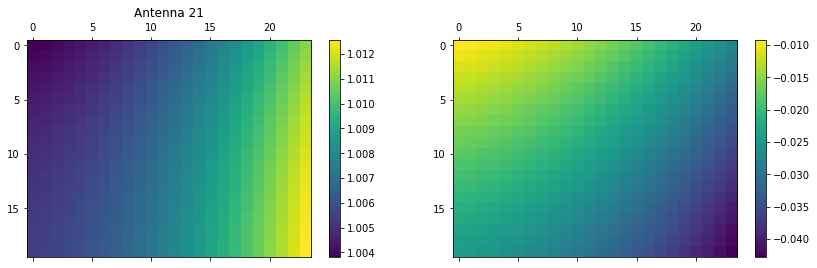

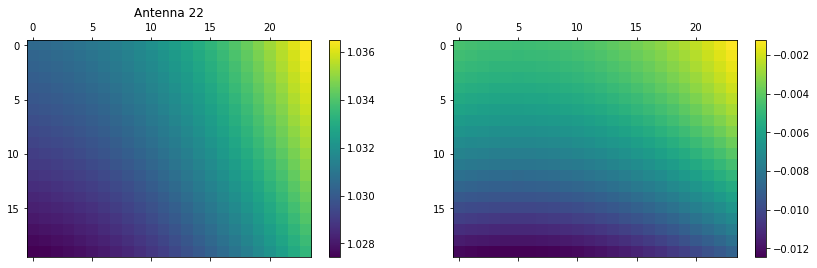

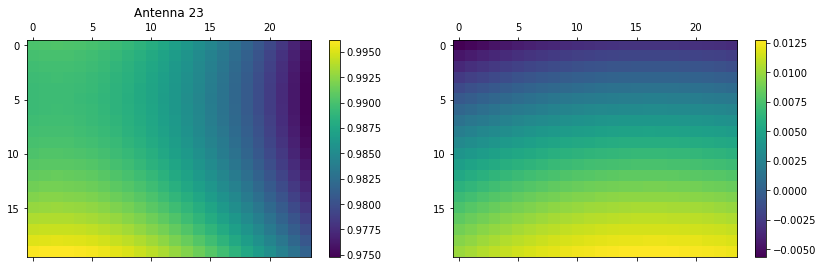

In [13]:
gains = np.zeros((len(ants), Nfreqs, Ntimes), dtype=complex)

# Loop over ants and simulate smooth complex gains
for ant in ants:
    # Generate polynomial coefficients in frequency and time
    f_coeffs = gain_poly_rms * (  1.0 * np.random.randn(gain_poly_order) \
                                + 1.j * np.random.randn(gain_poly_order) )
    t_coeffs = gain_poly_rms * (  1.0 * np.random.randn(gain_poly_order) \
                                + 1.j * np.random.randn(gain_poly_order) )
    
    # Variables (normalised)
    x_freq = np.linspace(0., 1., Nfreqs)
    x_time = np.linspace(0., 1., Ntimes)
    
    # Generate gain for this antenna
    gains[ant,:,:] = 1. \
                 + np.poly1d(f_coeffs)(x_freq)[:,np.newaxis] \
                 + np.poly1d(t_coeffs)(x_time)[np.newaxis,:]
    
    # Plot real and imaginary parts
    plt.subplot(121)
    plt.matshow(gains[ant].real, aspect='auto', fignum=False)
    plt.colorbar()
    plt.title("Antenna %d" % ant)
    
    plt.subplot(122)
    plt.matshow(gains[ant].imag, aspect='auto', fignum=False)
    plt.colorbar()
    plt.gcf().set_size_inches((14., 4.))
    plt.show()

### Primary beams
For now, we use identical Airy primary beams

In [14]:
beams = [pyuvsim.AnalyticBeam('airy', diameter=14.6) for ant in ants]

### Simulate point source visibilities
We use vis_cpu to simulate the point source visibilities

In [15]:
# Construct fluxes array by multiplying by powerlaw frequency dependence
fluxes = ptsrc_flux[:,np.newaxis] * (freqs[np.newaxis,:] / 100.)**ptsrc_beta[:,np.newaxis]

In [16]:
# Simulate visibilities
t0 = time.time()
vis = vis_cpu.simulate_vis(ants=ants, 
                           fluxes=fluxes, 
                           ra=np.deg2rad(ra), 
                           dec=np.deg2rad(dec), 
                           freqs=freqs*1e6, 
                           lsts=lsts, 
                           beams=beams, 
                           precision=2, 
                           polarized=False,
                           latitude=location.lat.rad)
print("Run took %3.1f sec" % (time.time() - t0))

Run took 0.9 sec


Text(0, 0.5, 'LST [h]')

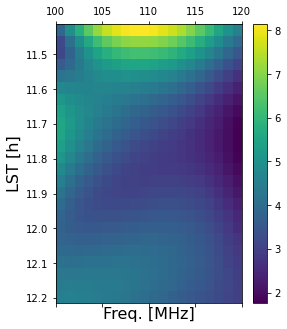

In [17]:
extent = [freqs.min(), freqs.max(), 
          lsts.max()*24./(2.*np.pi), lsts.min()*24./(2.*np.pi)]
plt.matshow(np.abs(vis[:,:,0,12]).T, aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Freq. [MHz]", fontsize=16.)
plt.ylabel("LST [h]", fontsize=16.)

### Output data

In [18]:
# Output point source catalogue
fname = "%s_source_catalogue.dat" % prefix
np.savetxt(fname, np.row_stack((ra, dec, ptsrc_flux, ptsrc_beta)))
print("Output point source catalogue: %s" % fname)

# Output gains
fname = "%s_gain_model" % prefix
np.save(fname, gains)
print("Output gain model: %s" % fname)

Output point source catalogue: sim_airy_100srcX_source_catalogue.dat
Output gain model: sim_airy_100srcX_gain_model


### Pack data into UVData objects

In [19]:
# Create empty UVData object for true visibility model
uvd = hera_sim.io.empty_uvdata(Ntimes=Ntimes, 
                               start_time=jd, 
                               integration_time=dt,
                               array_layout=ants,
                               Nfreqs=Nfreqs,
                               start_freq=freqs[0]*1e6,
                               channel_width=(freqs[1] - freqs[0])*1e6,
                               )
uvd.conjugate_bls('ant1<ant2')

# Loop over baselines and copy in data
for i in range(len(ants)):
    for j in range(i, len(ants)):
        y = vis[:,:,i,j].T
        uvd.set_data(y[:,np.newaxis,:,np.newaxis], (i,j))
uvd.write_uvh5("%s_sky_model.uvh5" % prefix, clobber=True)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [20]:
# For visibilities with gains applied
# Copy previous object and set data values to zero
uvd_g = uvd.copy()
uvd_g.data_array *= 0.

# Loop over baselines and copy in data
for i in range(len(ants)):
    for j in range(i, len(ants)):
        y = (gains[i] * gains[j].conj() * vis[:,:,i,j]).T
        uvd_g.set_data(y[:,np.newaxis,:,np.newaxis], (i,j))
uvd_g.write_uvh5("%s_data_model.uvh5" % prefix, clobber=True)

## Hydra

In [21]:
import sys
sys.path.insert(1, '/home/phil/hera/Hydra')
import hydra

In [22]:
# Telescope latitude
telescope_latitude = uvd.telescope_location_lat_lon_alt[0] # radians

# Get antenna info
ant_pos = hydra.utils.antenna_dict_from_uvd(uvd)
ants = np.array(list(ant_pos.keys()))
Nants = len(ants)

# Extract data and active baselines
data, antpairs, _ = hydra.extract_vis_from_uvdata(uvd, 
                                                  exclude_autos=True)
ants1, ants2 = list(zip(*antpairs))

# Times and frequencies
# (FIXME: Time ordering not guaranteed)
times = hydra.utils.extend_coords_with_padding(np.unique(uvd.lst_array)) # rad
freqs = hydra.utils.extend_coords_with_padding(np.unique(uvd.freq_array)/1e6) # MHz

# Load point source catalogue (ra/dec in degrees)
source_catalogue = "%s_source_catalogue.dat" % prefix
src_ra, src_dec, src_flux, src_beta = np.loadtxt(source_catalogue)
Nptsrc = src_ra.size
fluxes = hydra.utils.get_flux_from_ptsrc_amp(src_flux, freqs, src_beta, ref_freq=100.)
src_ra = np.deg2rad(src_ra)
src_dec = np.deg2rad(src_dec)
print("Source catalogue loaded from:", source_catalogue)

hera_latitude = -30.7215 * np.pi / 180.0

# Run simulation to construct initial model 
t0 = time.time()
sim_vis = hydra.vis_simulator.simulate_vis(
        ants=ant_pos,
        fluxes=fluxes,
        ra=src_ra,
        dec=src_dec,
        freqs=freqs*1e6, # MHz -> Hz
        lsts=times,
        beams=beams,
        polarized=False,
        precision=2,
        latitude=hera_latitude,
        use_feed="x",
    )

Source catalogue loaded from: sim_airy_100srcX_source_catalogue.dat


In [23]:
# Use Hydra simulations instead

# Create empty UVData object for true visibility model
uvd_h = uvd.copy()
uvd_h.data_array *= 0.

# Loop over baselines and copy in data
for i in range(len(ants)):
    for j in range(i, len(ants)):
        y = sim_vis[:,:,i,j].T
        uvd_h.set_data(y[:,np.newaxis,:,np.newaxis], (i,j))
uvd_h.write_uvh5("%s_hydra_sky_model.uvh5" % prefix, clobber=True)

# For visibilities with gains applied
# Copy previous object and set data values to zero
uvd_hg = uvd_h.copy()
uvd_hg.data_array *= 0.


# Loop over baselines and copy in data
for i in range(len(ants)):
    for j in range(i, len(ants)):
        y = (gains[i] * gains[j].conj() * sim_vis[:,:,i,j]).T
        uvd_hg.set_data(y[:,np.newaxis,:,np.newaxis], (i,j))
uvd_hg.write_uvh5("%s_hydra_data_model.uvh5" % prefix, clobber=True)